In [2]:
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
from numpy.fft import *
import pywt

In [4]:
from scipy.fftpack import dct, idct

In [5]:
import scipy.io
data = scipy.io.loadmat('brain.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'im', 'pdf_unif', 'mask_unif', 'pdf_vardens', 'mask_vardens'])

# Presentation of the data

The main data is a brain image acquired using MRI. As there are back and forth Fourier Transformations between the acquired signal and the reconstituted image, the pixels take a complex value instead of simple level of grays. To plot the image, we simply use the module of these complex numbers as shown below.

In addition to the image, we have :

- masks that represent a realistic way to subsample the data from the k-space as for a random acquisition
- probability density functions corresponding to the approximate probability each pixel would have to be drawn in the aforementioned acquisition.

Please note that these masks represent what would be a "random" draw, and do not represent a realistic way data could be acquired through the k-space by taking into account physical and mechanical limitations of the machine.

In [6]:
scan = data['im']

In [7]:
def plot_complex(array, bar=True):
    """Plot the module of a complex array.
    This is a convenience function."""
    plt.imshow(np.abs(array))
    if bar: 
        plt.colorbar()
    return np.abs(array)

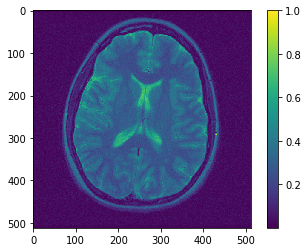

In [8]:
plot_complex(scan)
plt.show()

## Undersampled data

The goal of the application of CS to medical imagery is to be able to reduce the number of acquisition needed to get a correct picture. To approximate a way to do so from real data, we transform back our image to its k-space representation by an inverse Fourier Transform, and then select only a few points in this representation. When then transform back the zero-filled representation with a Fourier.

We plot the error, and calculate the global error as the Frobenius norm of the difference between the original and reconstructed matrix.

In [9]:
# Reproduce the matlab functions

def fft2c(scan):
    """Fourier Transform in 2D.
       The use of the shifts and the normalization assure that the data will stay in the 
       same magnitude after application of the transform and its inverse"""
    return 1/np.sqrt(scan.size) * fftshift(fft2(ifftshift(scan)))

def ifft2c(scan):
    """Inverse Fourier Transform in 2D."""
    return np.sqrt(scan.size) * ifftshift(ifft2(fftshift(scan)))

Error with the uniform undersampling reconstruction : 189.13140426274683
Error with the variable density undersampling reconstruction : 30.50576107701935


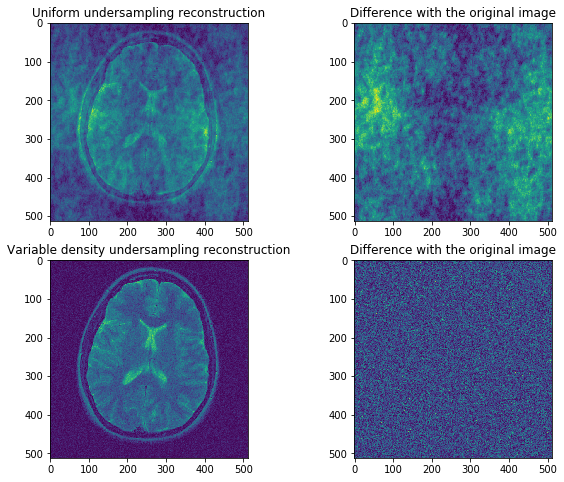

In [10]:
# Fourier transformation from image to k-space representation
k_space_transform = ifft2c(scan)

# Undersampling of the k-space
undersample_unif = k_space_transform * data['mask_unif'] / data['pdf_unif']
undersample_dens = k_space_transform * data['mask_vardens'] / data['pdf_vardens']

# Reconstruction with inverse Fourier transform on the undersampled data
rec_unif = fft2c(undersample_unif)
rec_vardens = fft2c(undersample_dens)

plt.figure(1, figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.title("Uniform undersampling reconstruction")
plot_complex(rec_unif, bar=False)

plt.subplot(2, 2, 2)
plot_complex(rec_unif - scan, bar=False)
plt.title("Difference with the original image")

print("Error with the uniform undersampling reconstruction : %s" % np.linalg.norm(rec_unif - scan))

plt.subplot(2,2,3)
plot_complex(rec_vardens, bar=False)
plt.title("Variable density undersampling reconstruction")

plt.subplot(2, 2, 4)
plot_complex(rec_vardens - scan, bar=False)
plt.title("Difference with the original image")

print("Error with the variable density undersampling reconstruction : %s" % np.linalg.norm(rec_vardens - scan))

plt.show()

As we can see above, the proportion of data that is acquired is not enough of an indicator to determine the quality of the reconstruction. It is quite logical that we need more data points near the center of the image where the actual points of interest are rather than on the edges we know for sure are empty.

## Using a large image

Before going further with our analysis, we wished to use a higher resolution image. We indeed noticed that the reconstruction using different algorithms and transformations were quite similar when using this small picture.

It also meant to modify our masks and probability distributions as seen below

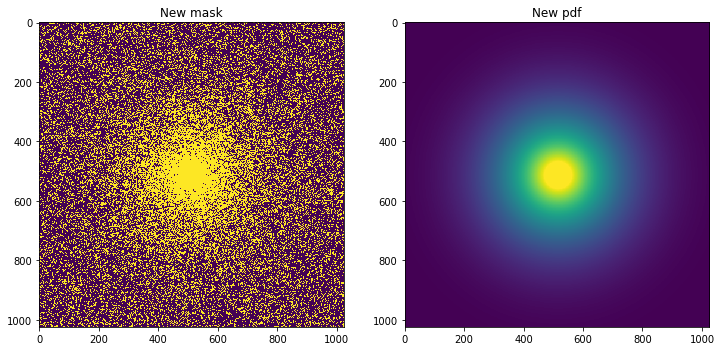

In [11]:
# Create new mask

mask_1024 = np.zeros([1024,1024])
for i in (range(len (mask_1024))):
    for j in (range(len (mask_1024))):
        row, column = np.random.binomial(1,1/2,size=2)
        mask_1024[i,j]=data["mask_vardens"][(i//2)-row,(j//2)-column]
        
        
# Create new pdf

pdf_vardens_1024 = np.zeros([1024,1024])
for i in (range (len (pdf_vardens_1024))):
    for j in (range (len (pdf_vardens_1024))):
        row_randomizer, column_randomizer = np.random.binomial(1,1/2,size=2)
        if i==(len (pdf_vardens_1024)-1):
            row_randomizer=0
        if j==(len (pdf_vardens_1024)-1):
            column_randomizer=0 
        pdf_vardens_1024[i,j]=data["pdf_vardens"][(i//2)-row,(j//2)-column]

plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_complex(mask_1024, bar=False)
plt.title("New mask")

plt.subplot(122)
plot_complex(pdf_vardens_1024, bar=False)
plt.title("New pdf")

plt.show()

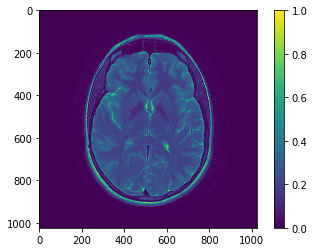

In [16]:
# Load the new image
from skimage import io
brain_1024 = io.imread('brain_1.jpg', as_grey=True)
scan = np.array(brain_1024)

plot_complex(scan)
plt.show()

## Measuring the incoherence

To assure a successful application of compressed sensing, we have to check that the artifacts in reconstruction from undersampling are incoherent, i.e they look like random noise.

The article proposes to use a point-spread-function, which is a matrix of the same size of the image with :

$PSF(i,j) = \Psi^* \mathcal{F}_S^* \mathcal{F}_S \Psi$

With :

- $\Psi$ and $\Psi^*$ a sparsfying transform and its adjoint operation.
- $\mathcal{F}_S$ and  $\mathcal{F}_S^*$ the undersampled Fourier Transform and its inverse.

Coherence can be visualized as the coefficients of the PSF outside the diagonal

In [17]:
def point_spread_function(transform, inverse_transform, mask=None, size=1000):
    """Compute a point spread matrix"""
    if mask is None :
        mask = 1
    else : # Override default or any given size
        size = mask.shape[0]
    mat_id = np.identity(size)
    return inverse_transform(ifft2c(fft2c(transform(mat_id)) * mask))

def plot_psf(psf_mat, bar=True):
    """Plot the point spread function of a transform function.
       As we do not care about the value of the diagonal, we remove it"""
    plt.imshow(np.abs(psf_mat - np.diag(np.diag(psf_mat))), cmap="YlOrBr")
    if bar: plt.colorbar()

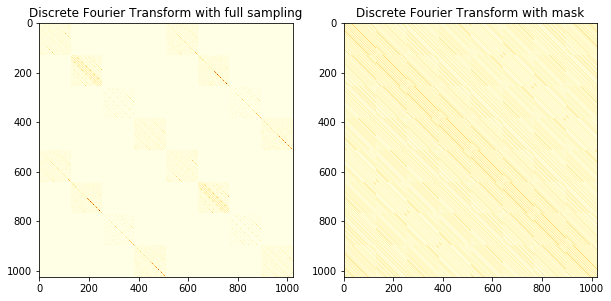

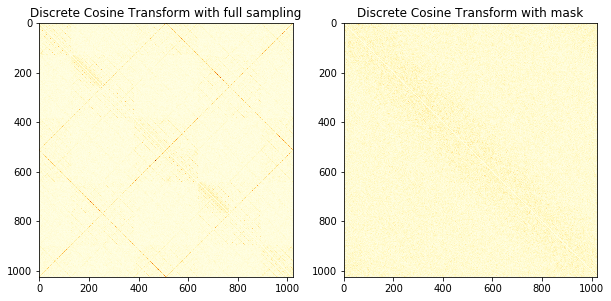

In [18]:
# With only the Fourier Transform
# Is equivalent to selecting the identity as transform function
psf_ft = point_spread_function(lambda x: x, lambda x: x, size=1024)
psf_ft_mask = point_spread_function(lambda x: x, lambda x: x, mask_1024)

# With discrete Cosine transform
psf_dct = point_spread_function(dct, idct, size=1024)
psf_dct_mask = point_spread_function(dct, idct, mask_1024)

plt.figure(1, figsize=(10, 8))
plt.subplot(121)
plot_psf(psf_ft, bar=False)
plt.title("Discrete Fourier Transform with full sampling")

plt.subplot(122)
plt.title("Discrete Fourier Transform with mask")
plot_psf(psf_ft_mask, bar=False)


plt.show()

 
plt.figure(2, figsize=(10, 8))
plt.subplot(121)
plot_psf(psf_dct, bar=False)
plt.title("Discrete Cosine Transform with full sampling")

plt.subplot(122)
plt.title("Discrete Cosine Transform with mask")
plot_psf(psf_dct_mask, bar=False)


plt.show()

_(please note that the scale is different in each graphic, we are more interested in the patterns here)_

As we can see, the leakage is much more spread when a mask is used, meaning that the energy leakage affects more cells, but also that the resulting representation will be less sparse.

## Wavelets

We now have a look at the wavelet transform of the image

In [19]:
cA, (cD1, cD2, cD3) = pywt.dwt2(scan, "db4")

In [20]:
rec_db4 = pywt.idwt2((cA, (cD1, cD2, cD3)), "db4")

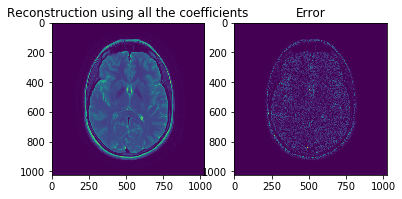

Error with wavelets : 3.8202435402369695e-14


In [21]:
plt.figure()
plt.subplot(1, 2, 1)
plot_complex(rec_db4, bar= False)
plt.title("Reconstruction using all the coefficients")

plt.subplot(1, 2, 2)
plot_complex(rec_db4 - scan, bar=False)
plt.title("Error")
plt.show()

print("Error with wavelets : %s" % np.linalg.norm(np.abs(rec_db4 - scan)))

As we can see, the reconstruction is virtually perfect when using all the coefficients for reconstruction.

### Sparsity of the representation

We have a look at the coefficients of the wavelet representation.

Even though not exactly sparse, a great proportion of those wavelet coefficients has a very small value.

In [20]:
# Check the sparsity of the coefficients
lam = 0.05

print("cA", np.sum(np.abs(cA) < lam)/ cA.size,
      "\ncD1", np.sum(np.abs(cD1) < lam)/ cD1.size,
     "\ncD2", np.sum(np.abs(cD2) < lam)/ cD2.size,
     "\ncD3", np.sum(np.abs(cD3) < lam)/ cD3.size)

cA 0.4171225831457492 
cD1 0.8683979070079456 
cD2 0.8594087744666895 
cD3 0.8988983467747946


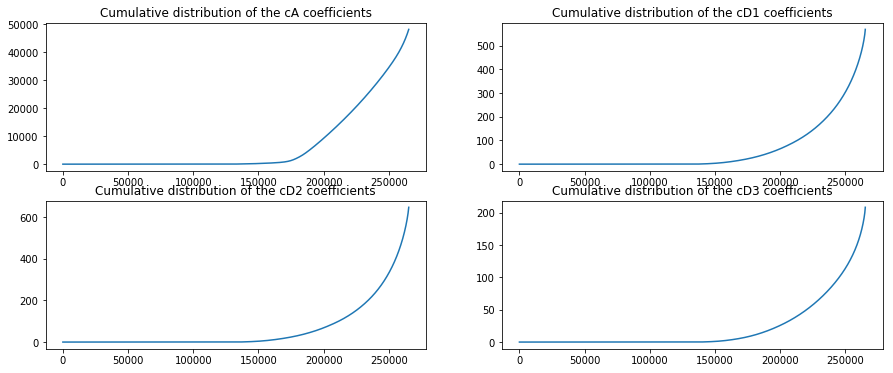

In [23]:
plt.figure(figsize=(15, 6))
plt.subplot(221)
plt.title("Cumulative distribution of the cA coefficients")
plt.plot(np.cumsum(sorted(np.abs(cA.reshape(-1)))))

plt.subplot(222)
plt.title("Cumulative distribution of the cD1 coefficients")
plt.plot(np.cumsum(sorted(np.abs(cD1.reshape(-1)))))

plt.subplot(223)
plt.title("Cumulative distribution of the cD2 coefficients")
plt.plot(np.cumsum(sorted(np.abs(cD2.reshape(-1)))))

plt.subplot(224)
plt.title("Cumulative distribution of the cD3 coefficients")
plt.plot(np.cumsum(sorted(np.abs(cD3.reshape(-1)))))

plt.show()

As we can see on the graphs above, at least two third of the coefficients of each type are really close to 0.

This triggers the question : what happens if I reconstruct my image using only the biggest coefficients ? These should contribute the most to the overall picture, whil representing only a small fraction of the acquired data

### Select only a proportion of the coefficients

We try to see how the reconstruction works if we only take a small portion of the wavelet coefficients

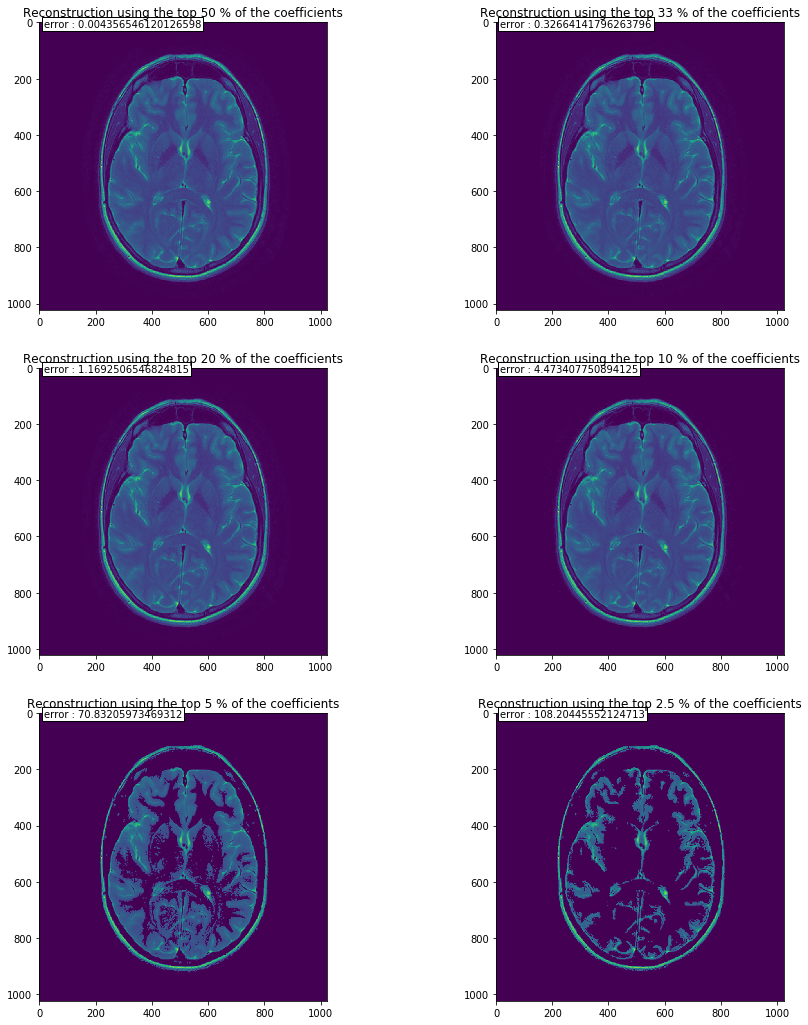

In [26]:
percentiles = [50, 33, 20, 10, 5, 2.5]
concatenated_coeffs = [i for coef in [cA, cD1, cD2, cD3] for i in np.abs(coef)]

plt.figure(figsize=(15, 18))

for i, perc in enumerate(percentiles):
    threshold = np.percentile(concatenated_coeffs, 100 - perc)
    cA_thresh = cA * (np.abs(cA) > threshold)
    cD1_thresh = cD1 * (np.abs(cD1) > threshold)
    cD2_thresh = cD2 * (np.abs(cD2) > threshold)
    cD3_thresh = cD3 * (np.abs(cD3) > threshold)
    rec_thresholded = pywt.idwt2((cA_thresh, (cD1_thresh, cD2_thresh, cD3_thresh)), "db4")
    plt.subplot((len(percentiles)+1)//2, 2, i+1)
    plot_complex(rec_thresholded, bar=False)
    plt.title("Reconstruction using the top %s %% of the coefficients" % perc)
    plt.text(15, 15, "error : %s" % np.linalg.norm(rec_thresholded - scan), bbox={'facecolor':'white', 'alpha':1, 'pad':2})

As we can see, the reconstruction error stays low even when using only 10% of the coefficients

## Soft Thresholding

Our previous experimentation with wavelets leads us to think that a correct reconstruction is possible only when using the biggest components of a representation.

Furthermore, as we are looking for a good reconstruction with a sparse representation, our objective is written.

$\arg \min_{\mathbf{x}} {||\mathbf{x} - \mathbf{b}||_{2}}^{2} +~\lambda ||\mathbf{x}||_{1}$

The soft thresholding algorithm is designed to solve this problem in a quick fashion.

In [28]:
def softthresh_c(x, lam):
    """Soft threshold function on complex numbers.
       We add a very small value to the division to not get an error if abs(x) is 0"""
    return (np.abs(x) > lam) * (np.abs(x) - lam) * x / (np.abs(x) + 1e-30)

In [44]:
def pocs_sparsifying_transform(scan, lam, mask, epsilon=0, max_iter = 1e6, history=0,
            ftransform=fft2c, i_ftransform=ifft2c, stransform_threshold=softthresh_c,
            pdf_adjust=1, **kwargs):
    """Apply the reconstruction algorithm described in the Berkeley exercise on the image.
    scan : original data
    lam : lambda parameter for the soft-thresholding
    mask : boolean array where observed data points are True. 
            If none is provided, create it with all the non-zero data points in y
    epsilon : difference of the l2 norm between two iterations under which the algorithm stops.
    max_iter : maximum number of iterations, default is one million, virtually everything converges before default value
    history : store the results of every (number given) of iterations in a list
    ftransform : Fourier Transform function to use,
    i_ftransform : Inverse Fourier Transform function to use
    stransform_threshold : use a sparsifying transform applies a soft threshold and then the inverse transform.
            Must take x and lam as arguments and potentially kwargs.
            Default is to not transform anything and apply softthresh_c
    pdf_adjust: number or array of the same size of scan. probability density adjustment of the masked sample."""
    
    # Check if there is at least one criterion to stop
    if not (epsilon or max_iter):
        raise ValueError("An escape criterion must be set")

    # Prepare the data    
    y = ftransform(scan) * mask / pdf_adjust
    
    # Initialization
    new_y = y
    diff = epsilon + 1
    n_iter = 0
    historical_rec = []
        
    while diff > epsilon and n_iter < max_iter :
        old_y = new_y.copy() # copy the result of the previous iteration
        x = i_ftransform(new_y) # Go back to pixel representation
        new_x = stransform_threshold(x, lam, **kwargs) # Transform to a sparse domain, applies soft threshold then goes back to the pixel domain
        new_y = ftransform(new_x)
        
        new_y = new_y * (y == 0) + y # Modify only the pixel we didn't actually observe
        diff = np.linalg.norm(np.abs(i_ftransform(new_y) - i_ftransform(old_y))) # See how much the results has changed regarding the l2 norm
        
        
        if history and n_iter % history == 0:
            historical_rec.append(i_ftransform(new_y))
            
        n_iter += 1
    
    if history:
        return i_ftransform(new_y), historical_rec # return breaks the function, no need for an else clause
    return i_ftransform(new_y)


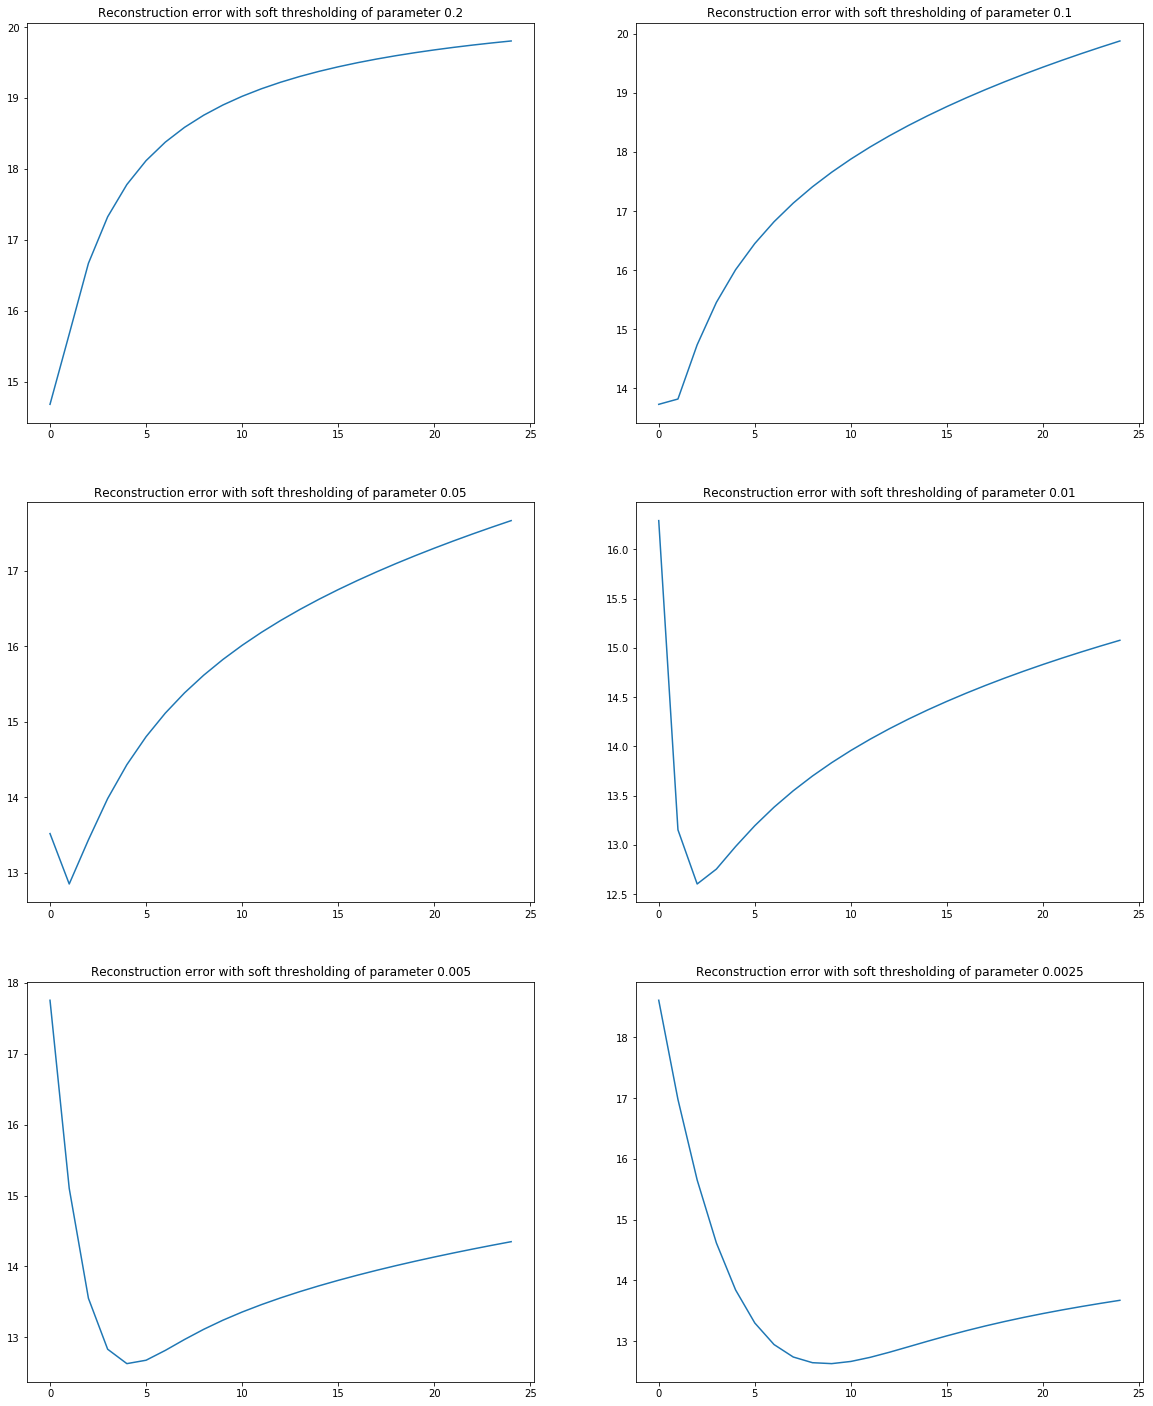

In [55]:
plt.figure(figsize=(20,25))

for i, lam in enumerate([0.2, 0.1, 0.05, 0.01, 0.005, 0.0025]):
    res, history = pocs_sparsifying_transform(scan, lam, mask_1024, max_iter=50, 
                                              history=2, pdf_adjust=pdf_vardens_1024)
    plt.subplot(3, 2, i+1)
    plt.plot([np.linalg.norm(rec - scan) for rec in history])
    plt.title("Reconstruction error with soft thresholding of parameter %s" % lam)
    
plt.show()

As we can see, using only the soft thresholding does not yield very good results, and the algorithm diverges for every parameter we tried, with an error at around 13 in the best case for the right number of iterations.

The reason behind this might be that our representation in the pixel domain is not "close enough" to sparsity, thus preventing the soft threshold algorithm to be efficient.

## Combining Wavelets and soft thresholding

As we have seen previously, we however know a domain where the representation is quite sparse ! Trying to apply soft thresholding to the wavelt domain could yield better results

In [48]:
def wavelet_transform_thr(x, lam, type_wavelet="db4"):
    """Transform x to the wavelet domain, applies soft threshold with lam parameter, 
        then goes back to the original domain."""
    cA, (cD1, cD2, cD3) = pywt.dwt2(x, type_wavelet)
    cD1 = softthresh_c(cD1, lam) # Apply soft-thresholding on each detail layer
    cD2 = softthresh_c(cD2, lam)
    cD3 = softthresh_c(cD3, lam)
    cA = softthresh_c(cA, lam)
    return pywt.idwt2((cA, (cD1, cD2, cD3)), type_wavelet)

In [49]:
res, history = pocs_sparsifying_transform(scan, 0.025, mask_1024,  max_iter=30, history=1,
                                          stransform_threshold=wavelet_transform_thr)

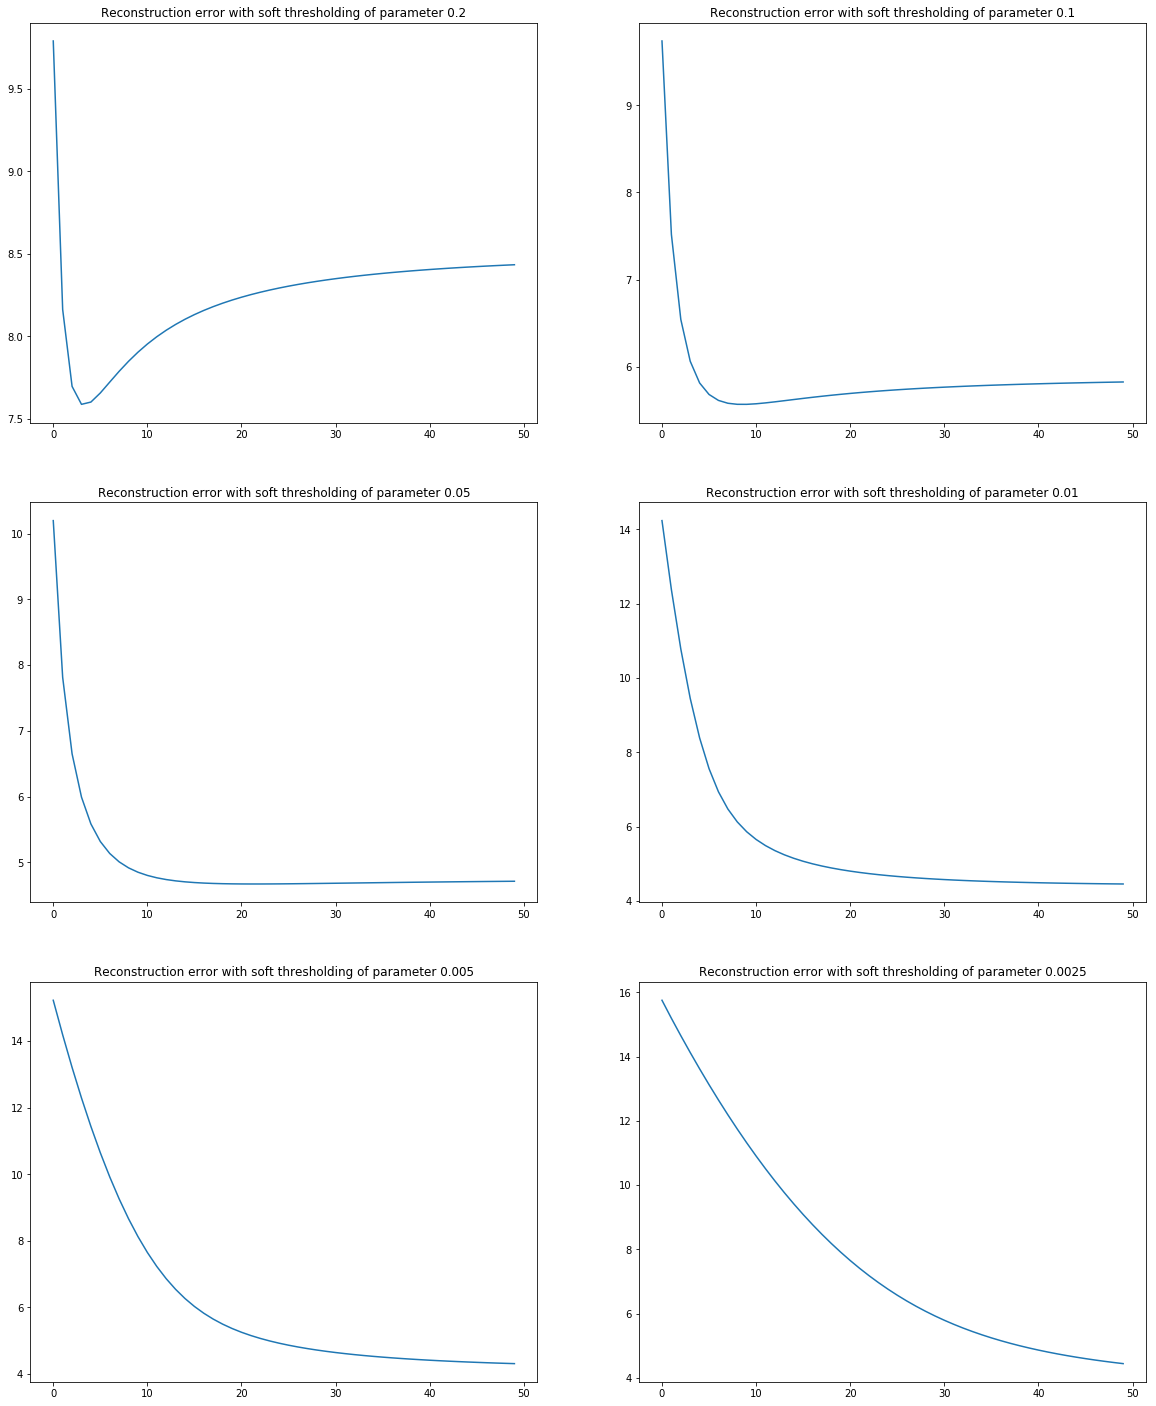

In [56]:
plt.figure(figsize=(20,25))

for i, lam in enumerate([0.2, 0.1, 0.05, 0.01, 0.005, 0.0025]):
    res, history = pocs_sparsifying_transform(scan, lam, mask_1024, max_iter=50, 
                                              history=1, stransform_threshold=wavelet_transform_thr)
    plt.subplot(3, 2, i+1)
    plt.plot([np.linalg.norm(rec - scan) for rec in history])
    plt.title("Reconstruction error with soft thresholding of parameter %s" % lam)
    
plt.show()

The reconstruction algorithm seems to converge towards a lower error than by simply using the soft threshold without the wavelet transform.

We plot our best reconstruction and its difference with the original image.

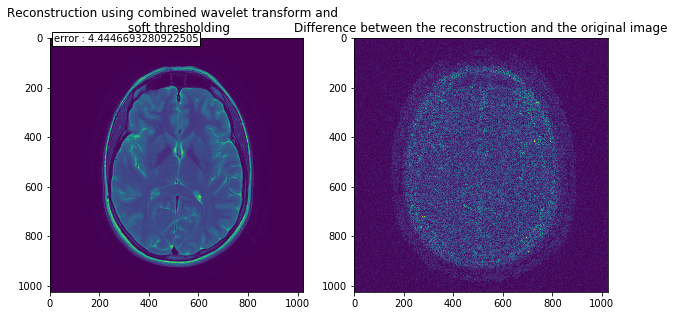

In [58]:
reconstruction = history[-1]

plt.figure(figsize=(10, 15))

plt.subplot(121)
plot_complex(reconstruction, bar=False)
plt.title("Reconstruction using combined wavelet transform and  \n soft thresholding")
plt.text(15, 15, "error : %s" % np.linalg.norm(reconstruction - scan), bbox={'facecolor':'white', 'alpha':1, 'pad':2})

plt.subplot(122)
plot_complex(reconstruction - scan, bar=False)
plt.title("Difference between the reconstruction and the original image")

plt.show()

As we can see our reconstruction error is concentrated around the actual content of the image, meaning that our algorithm successfuly corrected the "noise-like" error on the corners.

# Going Further

Our experimentation on the application of compressed sensing to the domain of medical imagery is still limited to a specifing sampling scheme, specific transforms and only brain imagery.

Compressed sensing can be applied to a wider range of problemns in medical imagery, however those different problem require different "tools" like different sampling schemes or transforms.

We are going to show in this last section several ideas we have to pursue this implementation.

## Trying other types of sparsifying transforms

Our implementation with wavelet seemed to work well, however there could be other sparsifying transform that would work

### Discrete Cosine Transform

We try to use the Discrete Cosine transform, which is used for example in the JPEG compression format.

In [59]:
def dct_thresh(x, lam):
    """Compute the Discrete Cosine Transform, applies a soft threshold then applies the inverse DCT (with normalization)."""
    w = dct(x)
    new_w = softthresh_c(w, lam)
    return idct(new_w)/ w.sum()

In [61]:
res, history = pocs_sparsifying_transform(scan, 0.01, mask_1024, max_iter=100, history=1, 
                                            stransform_threshold=dct_thresh)

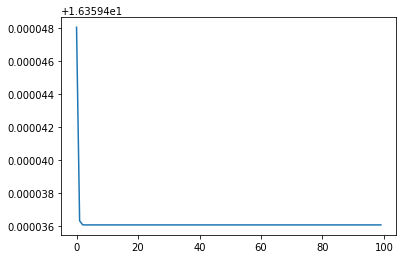

In [62]:
plt.plot([np.linalg.norm(rec - scan) for rec in history])
plt.show()

It seems that there is almost no evolution, in between each iteratio...

After further research, [this course](http://nptel.ac.in/courses/117105083/pdf/ssg_m3l9.pdf) illustrates the correct way to use a direct cosine transform in combination with a FFT. However, it is not clear if applying soft-thresholding on such results would yield correct results.

## Sampling in a different way

The sampling scheme we used was an expansion to fit our image of this [Berkely CS exercise](https://people.eecs.berkeley.edu/~mlustig/CS/CS_ex.pdf), however such sampling is not so easy to put into practice with the mecanichal limitations of an actual MRI machine.

### Creating a true Gaussian probability density function

We here just present a way to reproduce the given mask with an actual probability function.

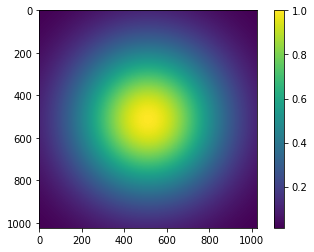

Mean value of the matrix ie estimated proportion of sampling : 0.3367


In [66]:
import numpy as np

def makeGaussian(size, fwhm = 600, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, dtype=float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    
    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

pdf_radius = makeGaussian(1024, fwhm=580)
# The probability of sampling on the edge is too small with this scheme
plot_complex(pdf_radius)
plt.show()

print("Mean value of the matrix ie estimated proportion of sampling : %0.4f" % pdf_radius.mean())


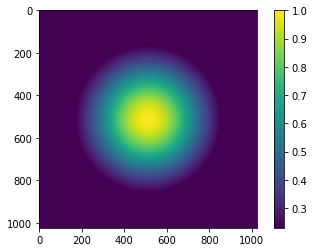

Mean value of the matrix ie estimated proportion of sampling : 0.3330


In [67]:
def makeGaussianWithMinimum(size, fwhm=600, center=None, minimum=0.22989655):
    gaussmat = makeGaussian(size, fwhm=fwhm) 
    return gaussmat * (gaussmat > minimum) + minimum * (gaussmat < minimum)

pdf_radius = makeGaussianWithMinimum(1024, 470)


plot_complex(pdf_radius)
plt.show()

print("Mean value of the matrix ie estimated proportion of sampling : %0.4f" % pdf_radius.mean())


In [70]:
def mask_from_pdf(pdf):
    """Create a mask from a probability density function.
        For each pixel, return the result of a Bernouli with parameter the value
        of the corresponding pixel in the pdf"""
    return np.random.binomial(1, pdf, pdf.shape)

Effective sampling rate : 0.3333


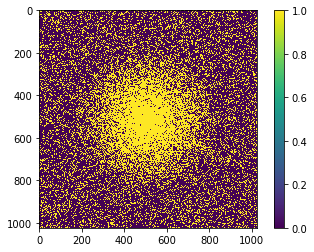

In [74]:
mask_radius = mask_from_pdf(pdf_radius)
print("Effective sampling rate : %0.4f" % mask_radius.mean())
plot_complex(mask_radius)
plt.show()

### Sampling random lines

An effective way to reduce number of acquisition with a scanner is simply to skip entire lines.

In [75]:
def gaussian_line_mask(size, peak_probability = 0.57, std_scaler=4):
    """Applies a random lines in 2D undersampling, based on Gaussian windows
        scan: original data
        peak_probability: parameter to control undersampling, (the smaller the more we undersample)
        std_scaler: other parameter to control undersampling, (the smaller, the lense dense at the center)
        """
    std = size/std_scaler

    threshholds = peak_probability * scipy.signal.gaussian(size, std)

    row_mask = np.random.rand(size)
    mask = np.zeros([size,size])
    mask[row_mask < threshholds,:] = 1.
    return mask

0.3369140625


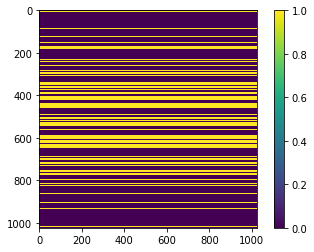

In [81]:
import scipy.signal

mask_gaussian=gaussian_line_mask(len(scan))
plot_complex(mask_gaussian)
print(mask_gaussian.mean())

We try this mask with a soft threhsolding and wavelet transform

In [98]:
res, history = pocs_sparsifying_transform(scan, 0.05, mask_gaussian,  max_iter=150, history=10,
                                          stransform_threshold=wavelet_transform_thr)

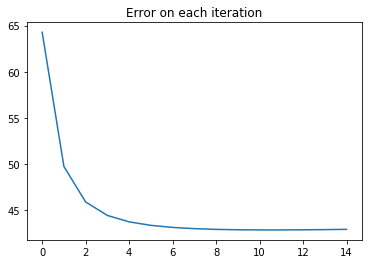

In [99]:
plt.plot([np.linalg.norm(rec - scan) for rec in history])
plt.title("Error on each iteration")
plt.show()

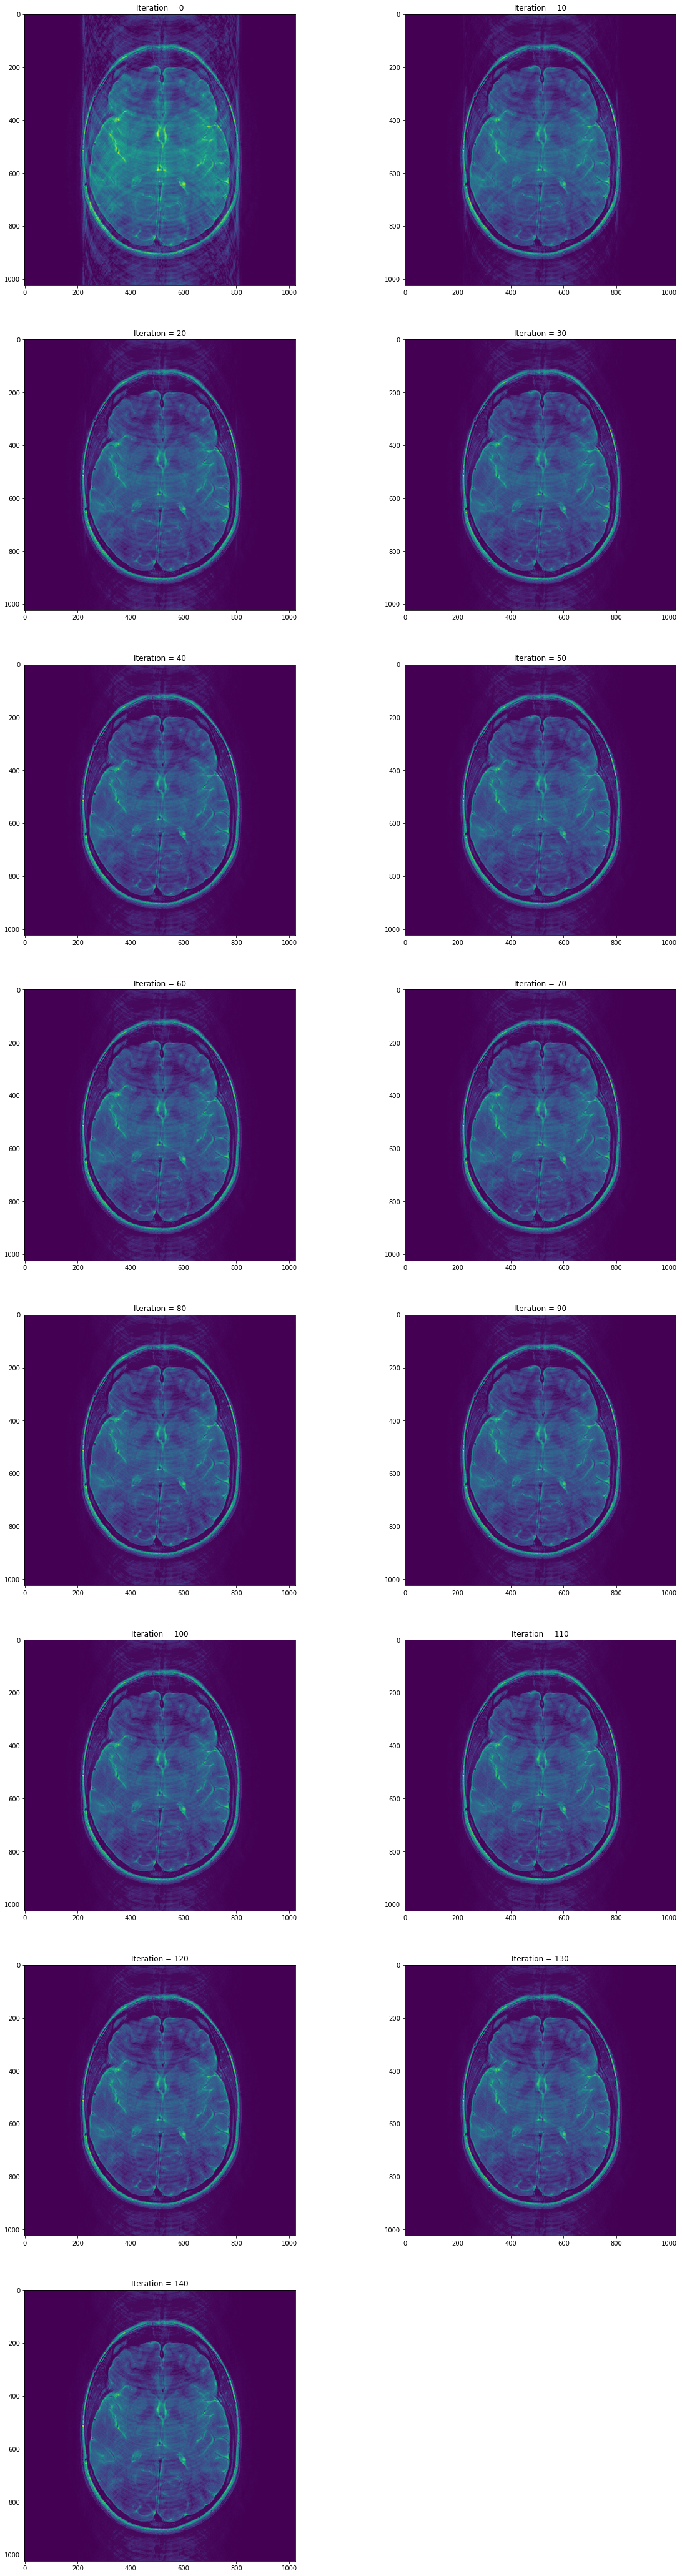

In [100]:
plt.figure(figsize=(20, 75))

for i, rec in enumerate(history):
    plt.subplot(8, 2, i+1)
    plot_complex(rec, bar=False)
    plt.title("Iteration = %s" % (i*10))

We see that our algorithm partly eliminates the reconstruction artifacts, however it seems that some is still present, and the error is much higher than with the "vardens" mask.

## Applying CS to an angiogram

We try to reproduce our analysis on an angiogram. As the blood vessels appear in black on the image, we use the inverse of this image.

We also select a subset of the image where the blood vessels are relatively centered, otherwise our centered sampling scheme would not work much

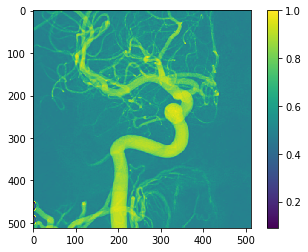

In [115]:
angio = io.imread('Capture3.JPG', as_grey=True)
scan2 = 1 - np.array(angio)[329:841, 25:537]

plot_complex(scan2)
plt.show()

In [120]:
# With gaussian line selection
mask_gaussian = gaussian_line_mask(len(scan2))

res, history = pocs_sparsifying_transform(scan2, 0.05, mask_gaussian,  max_iter=100, history=10,
                                          stransform_threshold=wavelet_transform_thr)

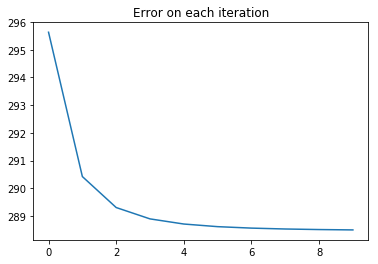

In [121]:
plt.plot([np.linalg.norm(rec - scan2) for rec in history])
plt.title("Error on each iteration")
plt.show()

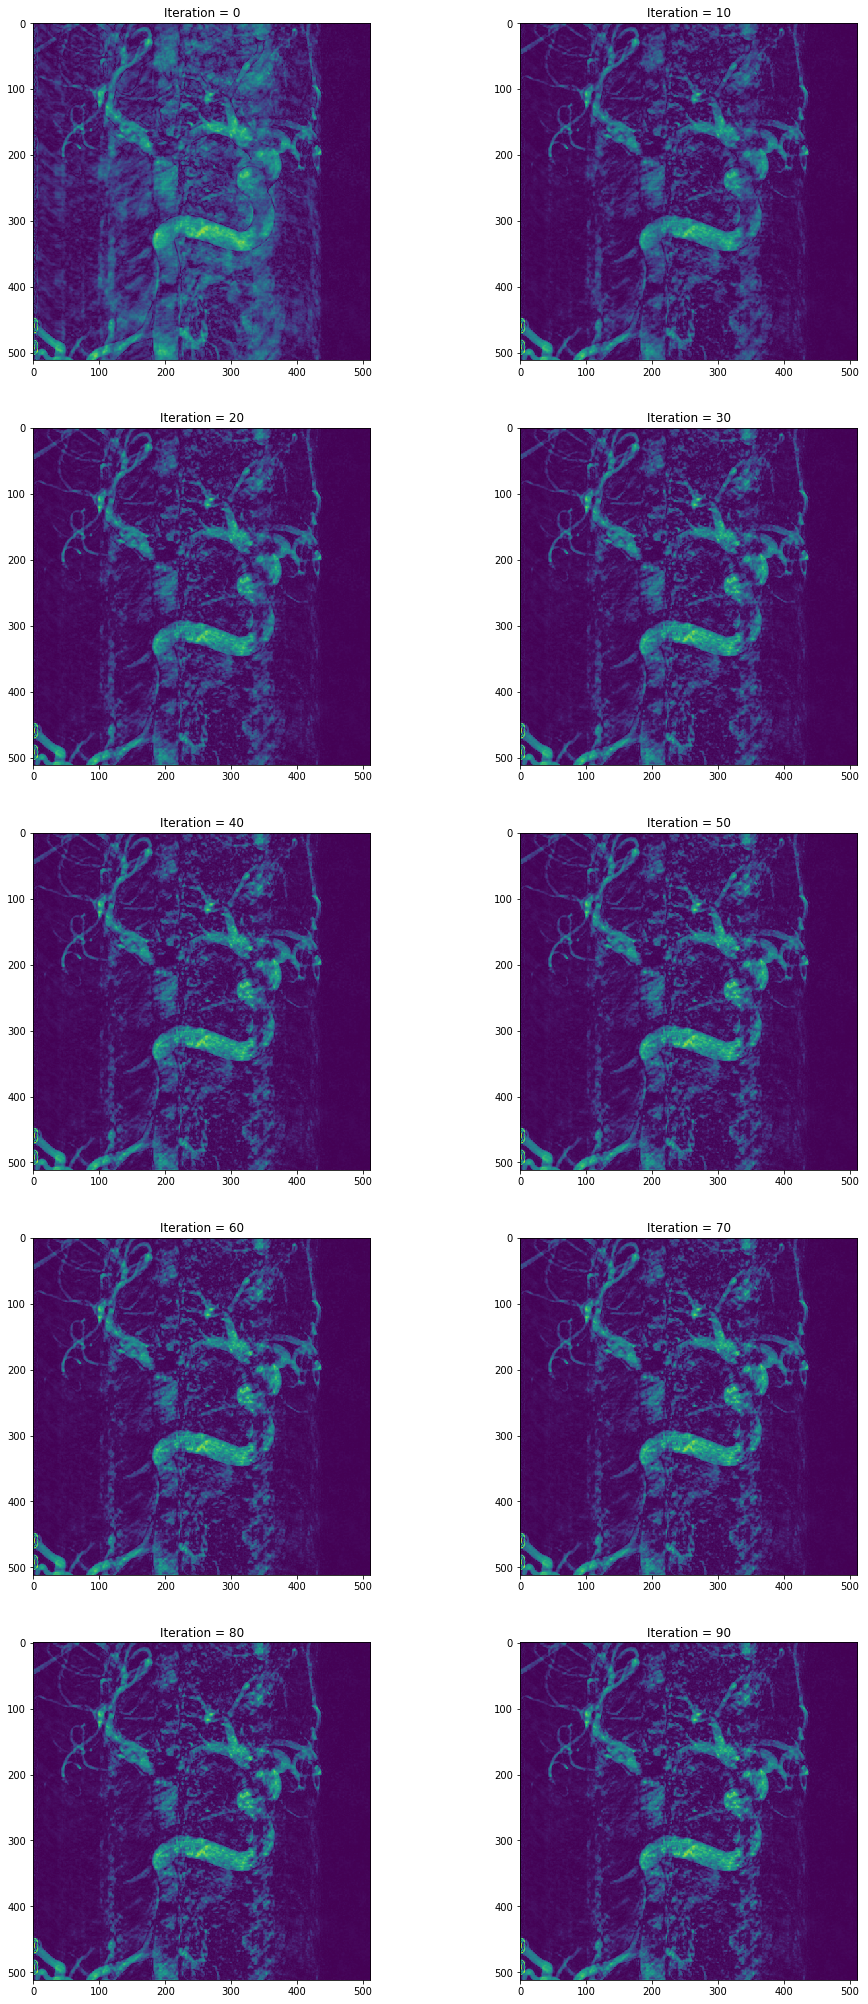

In [125]:
plt.figure(figsize=(16, 36))

for i, rec in enumerate(history):
    plt.subplot(5, 2, i+1)
    plot_complex(rec, bar=False)
    plt.title("Iteration = %s" % (i*10))
    
plt.show()

The reconstruction is not perfect but we can discern some of the blood vessels already.

Now with a centered gaussian pdf !

In [130]:
pdf_radius = makeGaussianWithMinimum(512, 235)
mask_radius = mask_from_pdf(pdf_radius)
print(mask_radius.mean()) # Sampling rate

res, history = pocs_sparsifying_transform(scan2, 0.05, mask_radius,  max_iter=100, history=10,
                                          stransform_threshold=wavelet_transform_thr)

0.33312225341796875


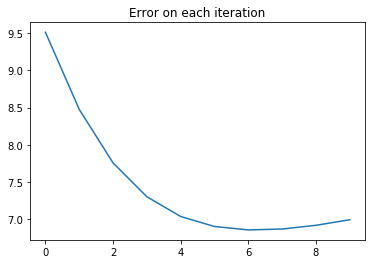

In [131]:
plt.plot([np.linalg.norm(rec - scan2) for rec in history])
plt.title("Error on each iteration")
plt.show()

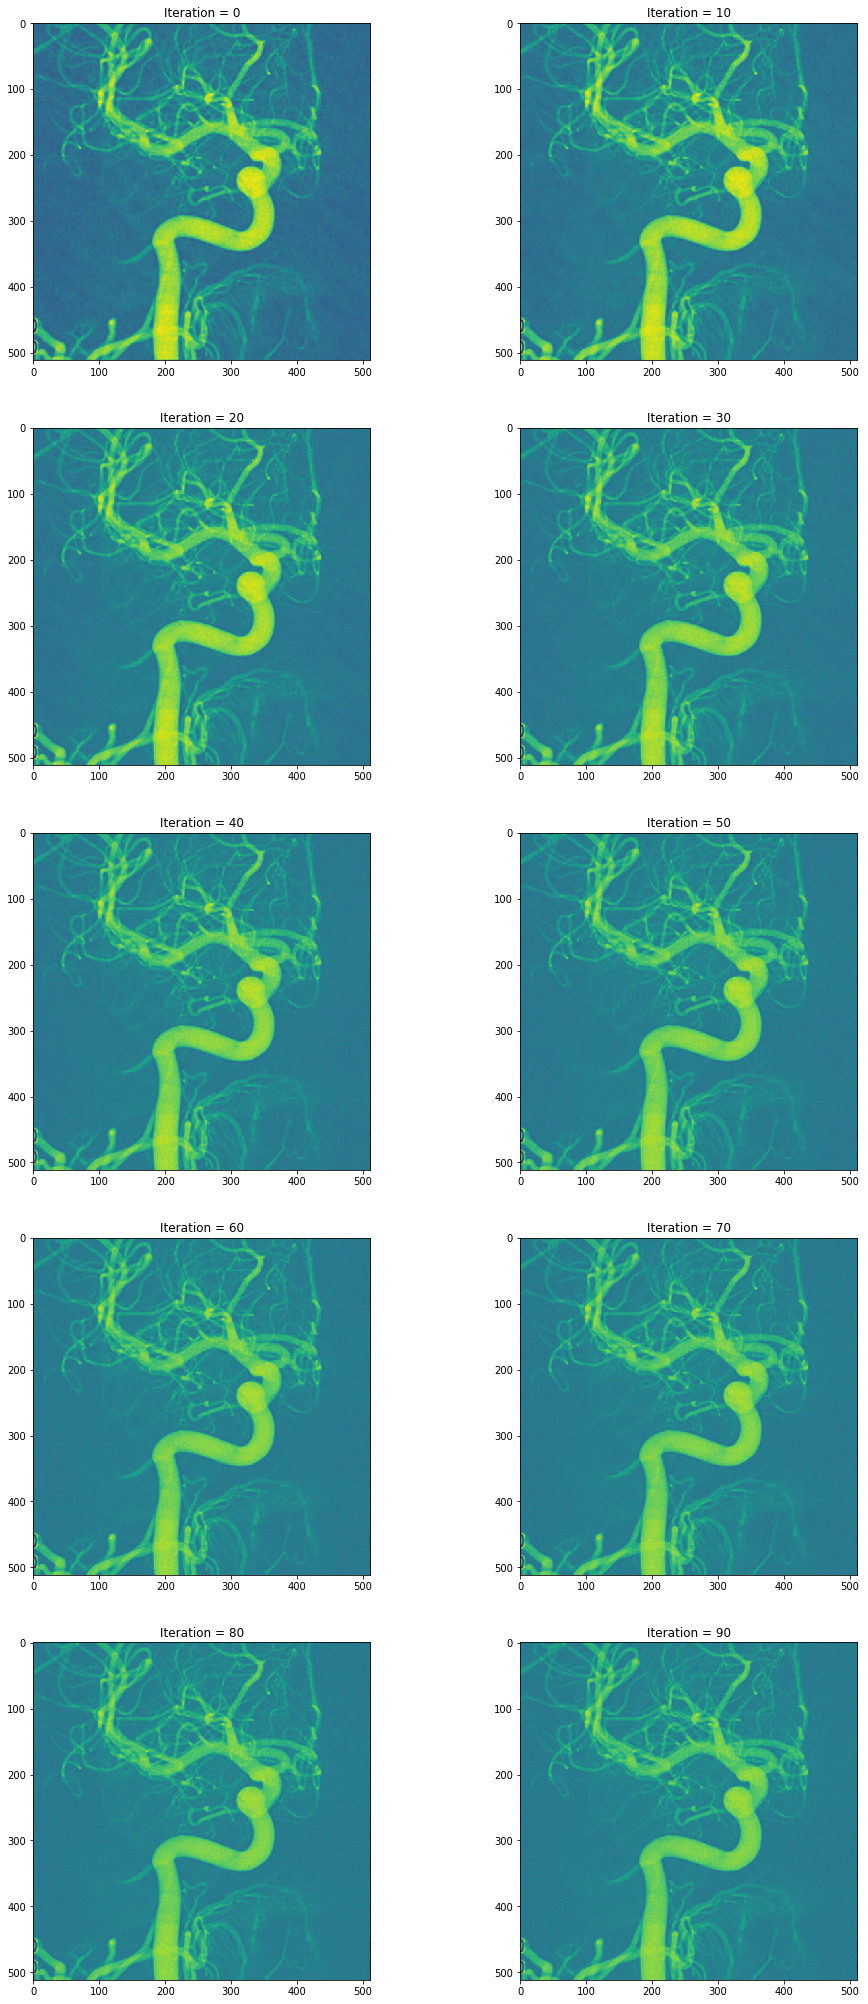

In [133]:
plt.figure(figsize=(16, 36))

for i, rec in enumerate(history):
    plt.subplot(5, 2, i+1)
    plot_complex(rec, bar=False)
    plt.title("Iteration = %s" % (i*10))
    
plt.show()

Our results seem quite good !
 
A way to better them would be to use a less centered sampling sceme, as there is more info on the edges with this type of image than there was with a brain scan